In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
# Installing pre-requisite for saving the model
!pip install pyyaml h5py

In [ ]:
# Mount google drive where dataset is stored at
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from random import randint

import os
import numpy as np
import pandas as pd

In [ ]:
# Configuration settings 
configs = {
    'epochs': 20,
    'batch_size': 32, 
    'seed': 7,
    'learning_rate': 1e-3, #0.001
    'hidden_activation': 'relu',
    'output_activation': 'sigmoid',
    'optimizer': 'adam',
    'loss_function': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'fc_layer_1_neurons' : 1024,
    'fc_layer_2_neurons' : 512,
    'fc_layer_3_neurons' : 256,
}

# Initialise Wandb
resnet_without_pretrained_celebA = wandb.init(
    name='resnet50V2_without_pretrained_celebA',
    project='CZ4042_Assignment_2_Resnet_Experiments',
    config= configs,
)

config = wandb.config
np.random.seed(config.seed)
tf.random.set_seed(config.seed)

In [ ]:
# Define the google drive path where data is stored
base_path = '/content/drive/MyDrive/CZ4042 Project Assignment 2/Models/'

# Load preprocessed dataset containing image path and gender as dataframe
df = pd.read_csv(base_path + 'processed_path_and_gender.txt', sep='\t')

# Split the dataset 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state = config.seed)

# Append the google drive path infront of the image path 
train_df['data_path'] = base_path + train_df['data_path'].astype(str)
test_df['data_path'] = base_path + test_df['data_path'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


4785    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


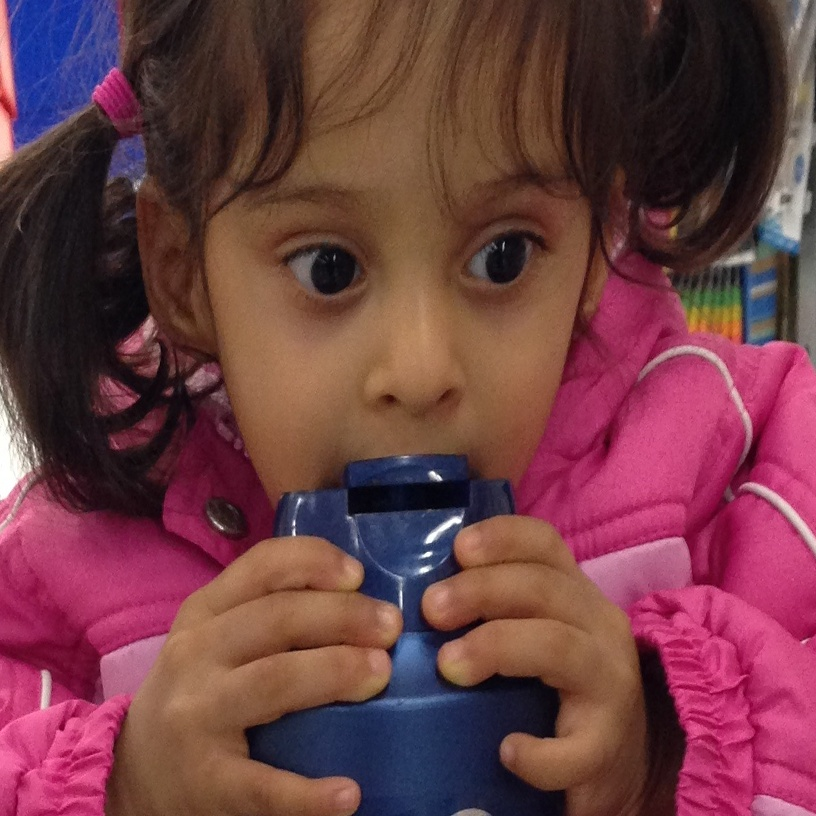

2865    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


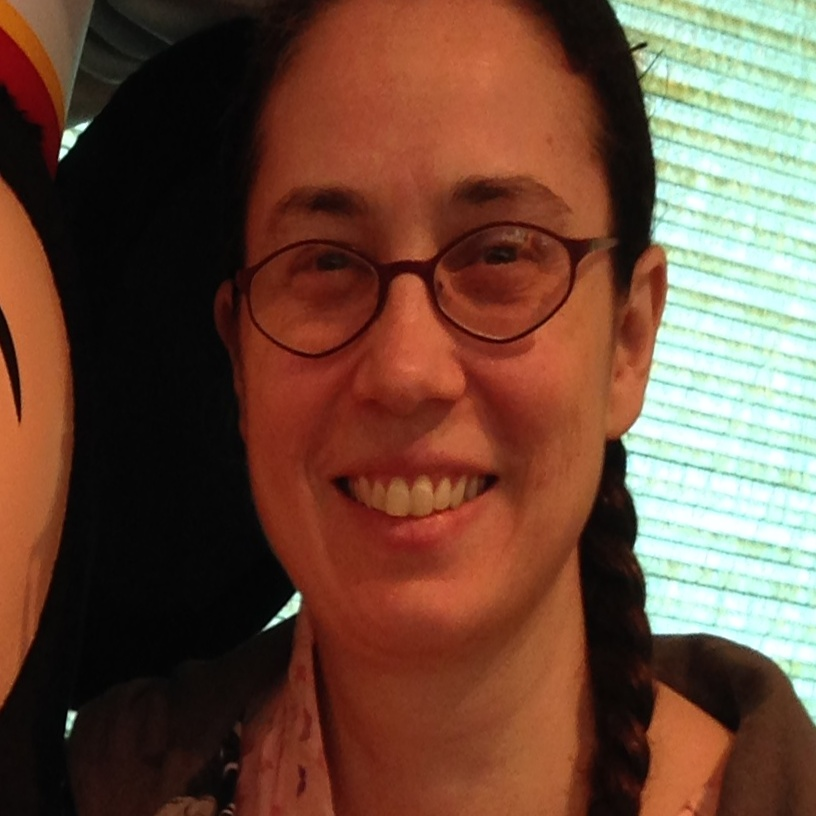

1088    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


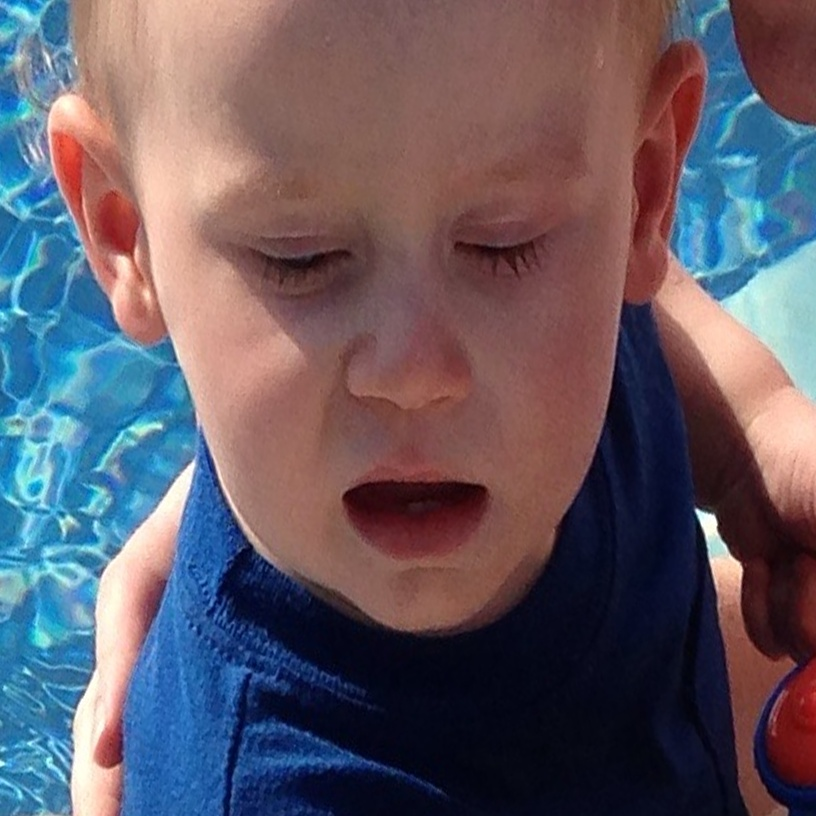

2618    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


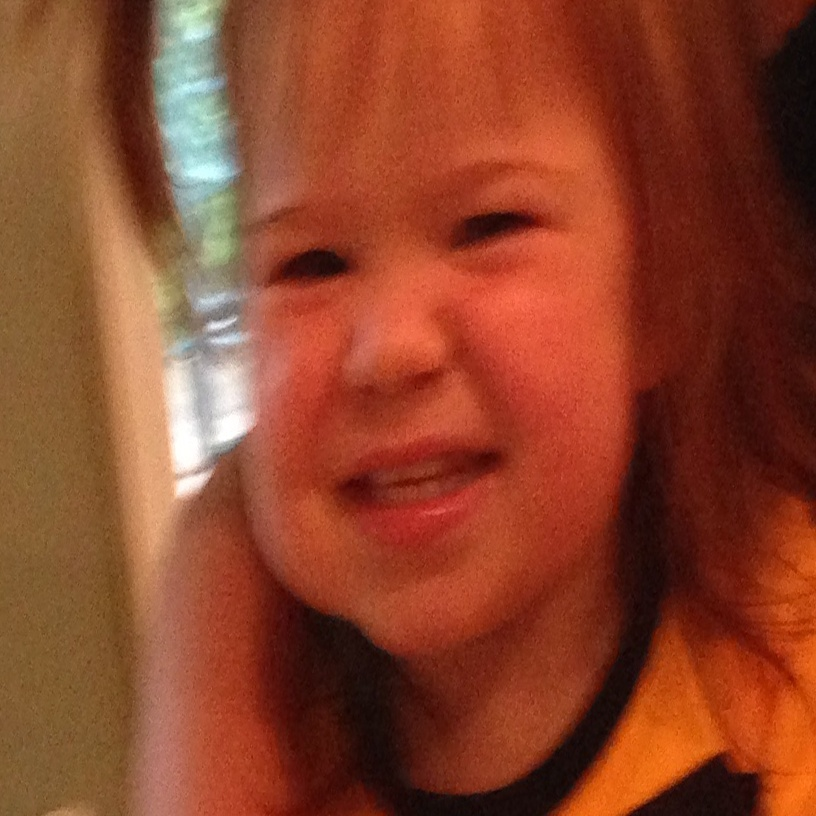

1521    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


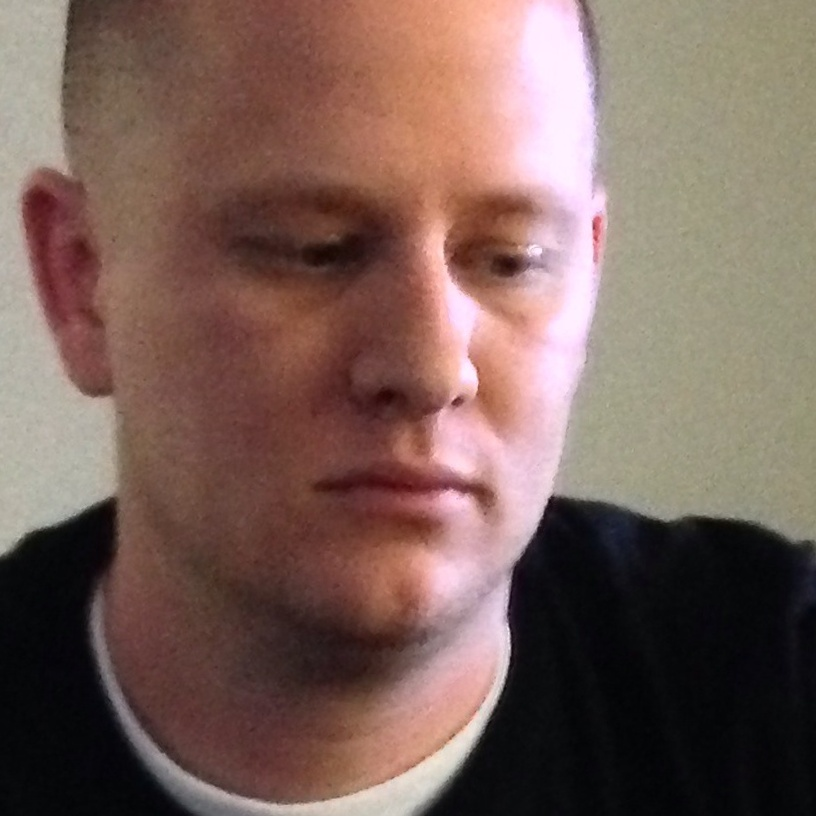

In [ ]:
# 5 random sample images from train_df
for i in range(5):
  randnum = randint(0, train_df.shape[0])
  print(train_df['data_path'].iloc[[randnum]])
  for imageName in train_df['data_path'].iloc[[randnum]]:
    display(Image(filename=imageName, width = 100, height = 100))

3415    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


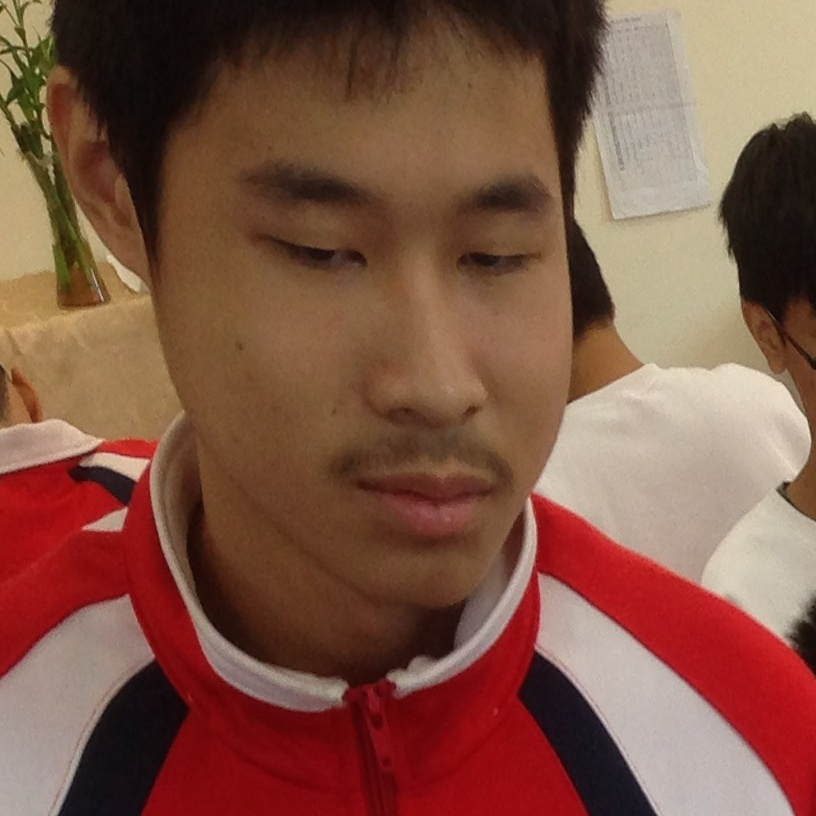

7352    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


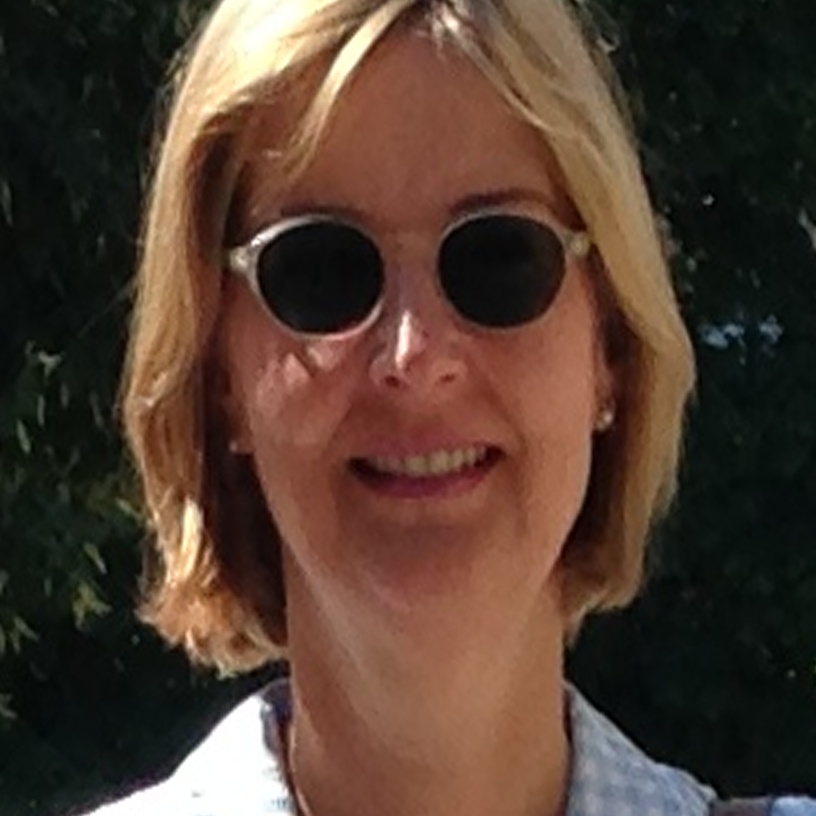

3409    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


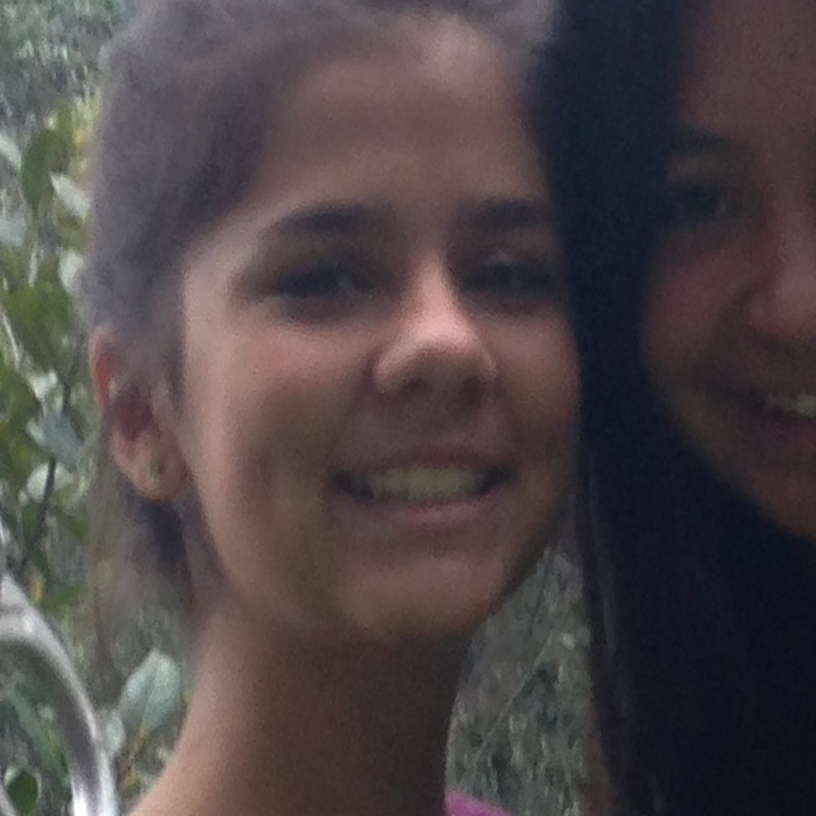

1897    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


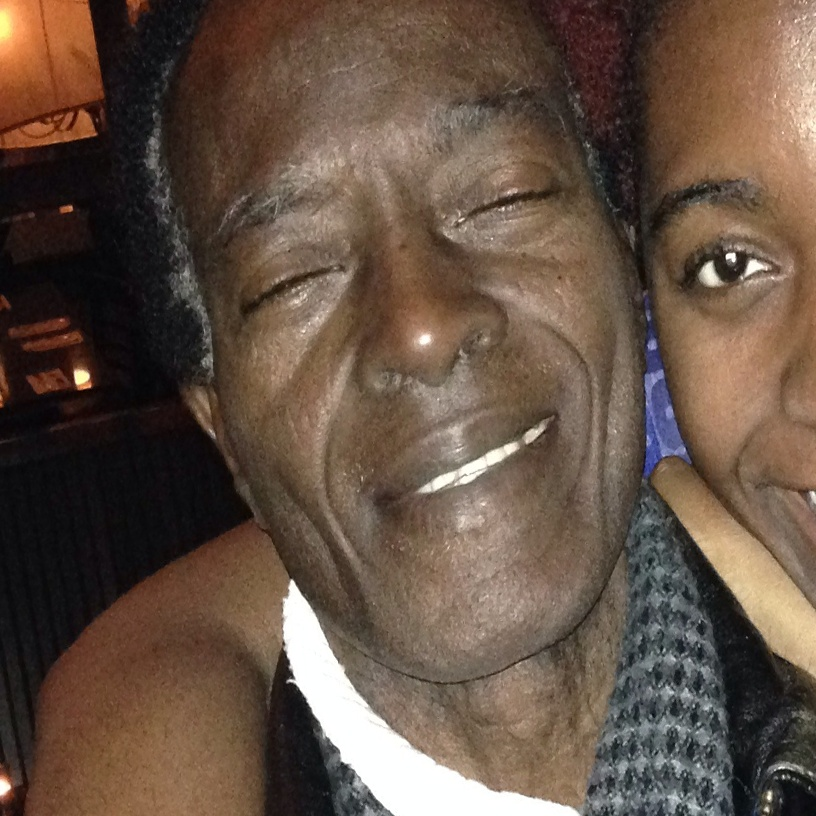

2504    /content/drive/MyDrive/CZ4042 Project Assignme...
Name: datadir, dtype: object


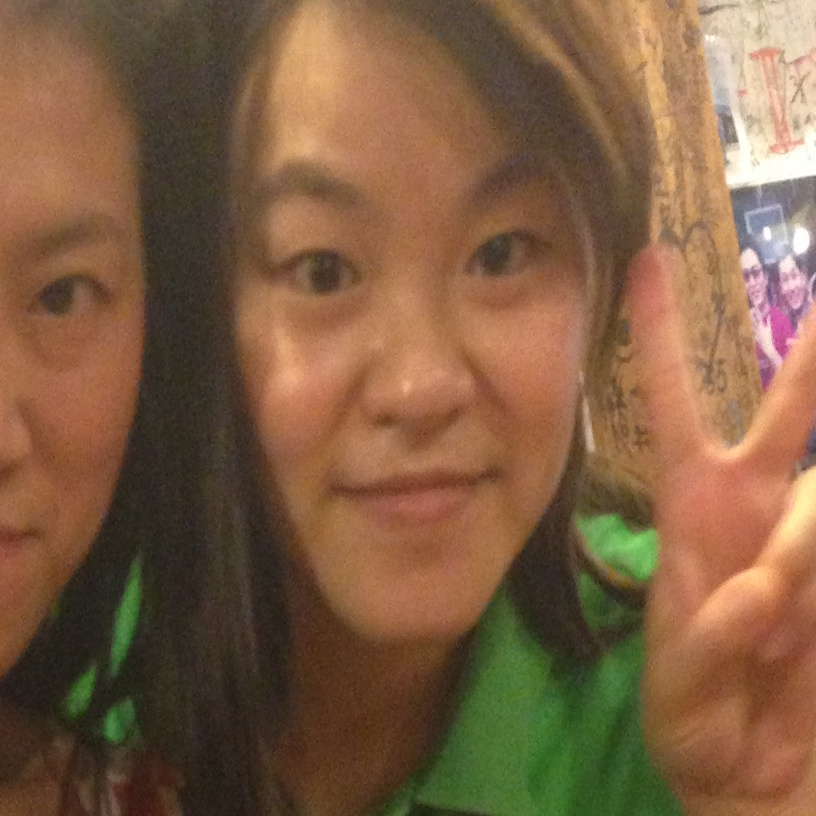

In [ ]:
# 5 random sample images from test_df
for i in range(5):
  randnum = randint(0, test_df.shape[0])
  print(test_df['data_path'].iloc[[randnum]])
  for imageName in test_df['data_path'].iloc[[randnum]]:
    display(Image(filename=imageName, width = 100, height = 100))

In [ ]:
# Initialise ImageDataGenerator 
# Perform rescaling using resnet50V2's preprocess_input method
train_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)
test_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)

# Generate the rescaled train images from the dataframe given 
train_ds = train_image_generated.flow_from_dataframe(
    dataframe = train_df,
    x_col ='data_path',
    y_col = 'gender',
    batch_size = config.batch_size,
    seed = config.seed,
    shuffle = True,
    class_mode ='raw',
    target_size = (224,224),
)

# Generate the rescaled test images from the dataframe given 
test_ds = test_image_generated.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'data_path',
    y_col = 'gender',
    batch_size = config.batch_size,
    seed = config.seed,
    shuffle = True,
    class_mode = 'raw',
    target_size = (224,224),
)

Found 9755 validated image filenames.
Found 2439 validated image filenames.


In [ ]:
# Creating the resnet50V2 model
def get_resnet50V2_model():

  seq = tf.keras.models.Sequential()

  seq.add(ResNet50V2(include_top=False, pooling = 'avg', weights ='imagenet', input_shape=(224,224,3)))

  seq.add(Flatten())

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_1_neurons, activation = config.hidden_activation))

  seq.add(tf.keras.layers.Dropout(0.5))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_2_neurons, activation = config.hidden_activation))

  seq.add(tf.keras.layers.Dropout(0.5))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_3_neurons, activation = config.hidden_activation))

  seq.add(tf.keras.layers.Dropout(0.5))

  seq.add(BatchNormalization())

  seq.add(Dense(1, activation= config.output_activation))

  seq.layers[0].trainable = False

  return seq

In [ ]:
model = get_resnet50V2_model()

# Compile the model
model.compile(
    optimizer = config.optimizer,
    loss = config.loss_function,
    metrics = config.metrics,
)

# View summary of model
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________

In [ ]:
# Checkpoint storing path
checkpoint_path = base_path + "Model Checkpoints/" + "resnet50V2_without_pretrained_celebA_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Model checkpoint to store best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Training the model
train_history = model.fit(
    train_ds,
    epochs= config.epochs,
    use_multiprocessing=True,
    callbacks=[model_checkpoint_callback, WandbCallback()],
    validation_data=test_ds,
)

Epoch 1/20
305/305 [==============================] - 6296s 21s/step - loss: 0.4568 - accuracy: 0.7891 - val_loss: 0.3661 - val_accuracy: 0.8475


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
305/305 [==============================] - 151s 494ms/step - loss: 0.3225 - accuracy: 0.8588 - val_loss: 0.2869 - val_accuracy: 0.8864
Epoch 3/20
305/305 [==============================] - 151s 494ms/step - loss: 0.2716 - accuracy: 0.8842 - val_loss: 0.2734 - val_accuracy: 0.8881
Epoch 4/20
305/305 [==============================] - 152s 500ms/step - loss: 0.2318 - accuracy: 0.9039 - val_loss: 0.2532 - val_accuracy: 0.8942
Epoch 5/20
305/305 [==============================] - 152s 497ms/step - loss: 0.2135 - accuracy: 0.9124 - val_loss: 0.2624 - val_accuracy: 0.8975
Epoch 6/20
305/305 [==============================] - 152s 498ms/step - loss: 0.1925 - accuracy: 0.9216 - val_loss: 0.2553 - val_accuracy: 0.8938
Epoch 7/20
305/305 [==============================] - 151s 494ms/step - loss: 0.1778 - accuracy: 0.9283 - val_loss: 0.2752 - val_accuracy: 0.8881
Epoch 8/20
305/305 [==============================] - 152s 498ms/step - loss: 0.1658 - accuracy: 0.9329 - val_loss: 0.2616 -

In [ ]:
# Save the resnet50V2 model into a .h5 file
model.save(base_path + 'Saved Models and Weights/' + 'my_resnet50V2_without_pretrained_celebA_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Evaluates the resnet50V2 model without pretraining and prints its accuracy
loss, acc = model.evaluate(
    test_ds,
    callbacks=[WandbCallback()],
)

print("Val_accuracy", acc)

77/77 [==============================] - 28s 356ms/step - loss: 0.2943 - accuracy: 0.8975
Val_accuracy 0.8974989652633667


In [ ]:
resnet_without_pretrained_celebA.finish()

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇██▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇▇▆▆▇███▇██▅▇█▇▇▇
val_loss,█▃▂▁▂▁▂▂▁▂▁▂▂▃▅▃▂▃▅▄
accuracy,0.95695
best_epoch,10
best_val_loss,0.2504
epoch,19
loss,0.11384
val_accuracy,0.8975
